# KinkedRconsumerType: Consumption-saving model with idiosyncratic income shocks and different interest rates on borrowing and saving

In [1]:
# Initial imports and notebook setup, click arrow to show

import matplotlib.pyplot as plt
import numpy as np

from HARK.ConsumptionSaving.ConsIndShockModel import KinkedRconsumerType
from HARK.utilities import plot_funcs_der, plot_funcs

mystr = lambda number: "{:.4f}".format(number)

/home/sb/projects/econ-ark/HARK/HARK/Calibration/Income/IncomeTools.py:449: UserWarning: Sabelhaus and Song (2010) provide variance profiles for ages 27 to 54. Extrapolating variances using the extreme points.
  warn(
/home/sb/projects/econ-ark/HARK/HARK/datasets/SCF/WealthIncomeDist/SCFDistTools.py:79: UserWarning: Returning SCF summary statistics for ages (20,25].
  warn("Returning SCF summary statistics for ages " + age_bracket + ".")


The module `HARK.ConsumptionSaving.ConsIndShockModel` concerns consumption-saving models with idiosyncratic shocks to (non-capital) income.  All of the models assume CRRA utility with geometric discounting, no bequest motive, and income shocks are fully transitory or fully permanent.

`ConsIndShockModel` currently includes three models:
1. A very basic "perfect foresight" model with no uncertainty.
2. A model with risk over transitory and permanent income shocks.
3. The model described in (2), with an interest rate for debt that differs from the interest rate for savings.

This notebook provides documentation for the third of these models.
$\newcommand{\CRRA}{\rho}$
$\newcommand{\DiePrb}{\mathsf{D}}$
$\newcommand{\PermGroFac}{\Gamma}$
$\newcommand{\Rfree}{\mathsf{R}}$
$\newcommand{\DiscFac}{\beta}$

## Statement of "kinked R" model

Consider a small extension to the model faced by `IndShockConsumerType`s: that the interest rate on borrowing $a_t < 0$ is greater than the interest rate on saving $a_t > 0$.  Consumers who face this kind of problem are represented by the $\texttt{KinkedRconsumerType}$ class.

For a full theoretical treatment, this model analyzed in [A Theory of the Consumption Function, With
and Without Liquidity Constraints](http://www.econ2.jhu.edu/people/ccarroll/ATheoryv3JEP.pdf)
and its [expanded edition](http://www.econ2.jhu.edu/people/ccarroll/ATheoryv3NBER.pdf).

Continuing to work with *normalized* variables (e.g. $m_t$ represents the level of market resources divided by permanent income), the "kinked R" model can be stated as:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} {~} U(c_t) + \DiscFac (1-\DiePrb_{t+1})  \mathbb{E}_{t} \left[ (\PermGroFac_{t+1}\psi_{t+1})^{1-\CRRA} v_{t+1}(m_{t+1}) \right], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& \Rfree_t/(\PermGroFac_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
\Rfree_t &=& \cases{\Rfree_{boro} \texttt{ if } a_t < 0 \\
                    \Rfree_{save} \texttt{ if } a_t \geq 0},\\
\Rfree_{boro} &>& \Rfree_{save}, \\
(\psi_{t+1},\theta_{t+1}) &\sim& F_{t+1}, \\
\mathbb{E}[\psi]=\mathbb{E}[\theta] &=& 1.
\end{eqnarray*}

## Solving the "kinked R" model

The solution method for the "kinked R" model is nearly identical to that of the `IndShockConsumerType` on which it is based, using the endogenous grid method; see the notebook for that model for more information.  The only significant difference is that the interest factor varies by $a_t$ across the exogenously chosen grid of end-of-period assets, with a discontinuity in $\Rfree$ at $a_t=0$.

To correctly handle this, the `solveConsKinkedR` function inserts *two* instances of $a_t=0$ into the grid of $a_t$ values: the first corresponding to $\Rfree_{boro}$ ($a_t = -0$) and the other corresponding to $\Rfree_{save}$ ($a_t = +0$).  The two consumption levels (and corresponding endogenous $m_t$ gridpoints) represent points at which the agent's first order condition is satisfied at *exactly* $a_t=0$  at the two different interest factors.  In between these two points, the first order condition *does not hold with equality*: the consumer will end the period with exactly $a_t=0$, consuming $c_t=m_t$, but his marginal utility of consumption exceeds the marginal value of saving and is less than the marginal value of borrowing.  This generates a consumption function with *two* kinks: two concave portions (for borrowing and saving) with a linear segment of slope 1 in between.

## Example parameter values to construct an instance of KinkedRconsumerType

The parameters required to create an instance of `KinkedRconsumerType` are nearly identical to those for `IndShockConsumerType`.  The only difference is that the parameter $\texttt{Rfree}$ is replaced with $\texttt{Rboro}$ and $\texttt{Rsave}$.

While the parameter $\texttt{CubicBool}$ is required to create a valid `KinkedRconsumerType` instance, it must be set to `False`; cubic spline interpolation has not yet been implemented for this model.  In the future, this restriction will be lifted.

| Parameter | Description | Code | Example value | Time-varying? |
| :---: | --- | --- | --- | --- |
| $\DiscFac$ |Intertemporal discount factor  | $\texttt{DiscFac}$ | $0.96$ |  |
| $\CRRA $ |Coefficient of relative risk aversion | $\texttt{CRRA}$ | $2.0$ | |
| $\Rfree_{boro}$ | Risk free interest factor for borrowing | $\texttt{Rboro}$ | $1.20$ | |
| $\Rfree_{save}$ | Risk free interest factor for saving | $\texttt{Rsave}$ | $1.01$ | |
| $1 - \DiePrb_{t+1}$ |Survival probability | $\texttt{LivPrb}$ | $[0.98]$ | $\surd$ |
|$\PermGroFac_{t+1}$|Permanent income growth factor|$\texttt{PermGroFac}$| $[1.01]$ | $\surd$ |
| $\sigma_\psi $ | Standard deviation of log permanent income shocks | $\texttt{PermShkStd}$ | $[0.1]$ |$\surd$ |
| $N_\psi $ | Number of discrete permanent income shocks | $\texttt{PermShkCount}$ | $7$ | |
| $\sigma_\theta $ | Standard deviation of log transitory income shocks | $\texttt{TranShkStd}$ | $[0.2]$ | $\surd$ |
| $N_\theta $ | Number of discrete transitory income shocks | $\texttt{TranShkCount}$ | $7$ |  |
| $\mho$ | Probability of being unemployed and getting $\theta=\underline{\theta}$ | $\texttt{UnempPrb}$ | $0.05$ |  |
| $\underline{\theta} $ | Transitory shock when unemployed | $\texttt{IncUnemp}$ | $0.3$ |  |
| $\mho^{Ret}$ | Probability of being "unemployed" when retired | $\texttt{UnempPrb}$ | $0.0005$ |  |
| $\underline{\theta}^{Ret} $ | Transitory shock when "unemployed" and retired | $\texttt{IncUnemp}$ | $0.0$ |  |
| $(none)$ | Period of the lifecycle model when retirement begins | $\texttt{T_retire}$ | $0$ | |
| $(none)$ | Minimum value in assets-above-minimum grid | $\texttt{aXtraMin}$ | $0.001$ | |
| $(none)$ | Maximum value in assets-above-minimum grid | $\texttt{aXtraMax}$ | $20.0$ | |
| $(none)$ | Number of points in base assets-above-minimum grid | $\texttt{aXtraCount}$ | $48$ | |
| $(none)$ | Exponential nesting factor for base assets-above-minimum grid | $\texttt{aXtraNestFac}$ | $3$ | |
| $(none)$ | Additional values to add to assets-above-minimum grid | $\texttt{aXtraExtra}$ | $None$ | |
| $\underline{a} $ | Artificial borrowing constraint (normalized) | $\texttt{BoroCnstArt}$ | $None$ | |
| $(none) $ |Indicator for whether $\texttt{vFunc}$ should be computed | $\texttt{vFuncBool}$ | $True$ | |
| $(none)$ |Indicator for whether $\texttt{cFunc}$ should use cubic splines | $\texttt{CubicBool}$ | $False$ |  |
|$T$| Number of periods in this type's "cycle" |$\texttt{T_cycle}$| $1$ | |
|(none)| Number of times the "cycle" occurs |$\texttt{cycles}$| $0$ | |

These example parameters are almostidentical to those used for `IndShockExample` in the prior notebook, except that the interest rate on borrowing is 20% (like a credit card), and the interest rate on saving is 1%. Moreover, the artificial borrowing constraint has been set to `None`.  The cell below defines a parameter dictionary with these example values.

In [2]:
KinkedRdict = {  # Click the arrow to expand this parameter dictionary
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,  # Coefficient of relative risk aversion
    "DiscFac": 0.96,  # Intertemporal discount factor
    "LivPrb": [0.98],  # Survival probability
    "PermGroFac": [1.01],  # Permanent income growth factor
    "BoroCnstArt": None,  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    # New parameters unique to the "kinked R" model
    "Rboro": 1.20,  # Interest factor on borrowing (a < 0)
    "Rsave": 1.01,  # Interest factor on saving (a > 0)
    # Parameters that specify the income distribution over the lifecycle (shared with IndShockConsumerType)
    "PermShkStd": [0.1],  # Standard deviation of log permanent shocks to income
    "PermShkCount": 7,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.2],  # Standard deviation of log transitory shocks to income
    "TranShkCount": 7,  # Number of points in discrete approximation to transitory income shocks
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "UnempPrbRet": 0.0005,  # Probability of "unemployment" while retired
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    "tax_rate": 0.0,  # Flat income tax rate (legacy parameter, will be removed in future)
    # Parameters for constructing the "assets above minimum" grid (shared with IndShockConsumerType)
    "aXtraMin": 0.001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 20,  # Maximum end-of-period "assets above minimum" value
    "aXtraCount": 48,  # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac": 3,  # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra": [None],  # Additional values to add to aXtraGrid
    # A few other paramaters (shared with IndShockConsumerType)
    "vFuncBool": True,  # Whether to calculate the value function during solution
    "CubicBool": False,  # Preference shocks currently only compatible with linear cFunc
    "T_cycle": 1,  # Number of periods in the cycle for this agent type
    # Parameters only used in simulation (shared with PerfForesightConsumerType)
    "AgentCount": 10000,  # Number of agents of this type
    "T_sim": 500,  # Number of periods to simulate
    "aNrmInitMean": -6.0,  # Mean of log initial assets
    "aNrmInitStd": 1.0,  # Standard deviation of log initial assets
    "pLvlInitMean": 0.0,  # Mean of log initial permanent income
    "pLvlInitStd": 0.0,  # Standard deviation of log initial permanent income
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor
    "T_age": None,  # Age after which simulated agents are automatically killed
}

## Solving and examining the solution of the "kinked R" model

The cell below creates an infinite horizon instance of `KinkedRconsumerType` and solves its model by calling its `solve` method.

In [3]:
KinkyExample = KinkedRconsumerType(**KinkedRdict)
KinkyExample.cycles = 0  # Make the example infinite horizon
KinkyExample.solve()

An element of a `KinkedRconsumerType`'s solution will have all the same attributes as that of a `IndShockConsumerType`; see that notebook for details.

We can plot the consumption function of our "kinked R" example, as well as the MPC:

Kinked R consumption function:


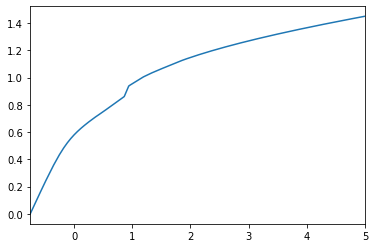

Kinked R marginal propensity to consume:


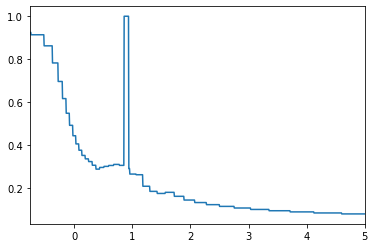

In [4]:
print("Kinked R consumption function:")
plot_funcs(KinkyExample.solution[0].cFunc, KinkyExample.solution[0].mNrmMin, 5)

print("Kinked R marginal propensity to consume:")
plot_funcs_der(KinkyExample.solution[0].cFunc, KinkyExample.solution[0].mNrmMin, 5)

## Simulating the "kinked R" model

In order to generate simulated data, an instance of `KinkedRconsumerType` needs to know how many agents there are that share these particular parameters (and are thus *ex ante* homogeneous), the distribution of states for newly "born" agents, and how many periods to simulated.  These simulation parameters are described in the table below, along with example values.

| Description | Code | Example value |
| :---: | --- | --- |
| Number of consumers of this type | $\texttt{AgentCount}$ | $10000$ |
| Number of periods to simulate | $\texttt{T_sim}$ | $500$ |
| Mean of initial log (normalized) assets | $\texttt{aNrmInitMean}$ | $-6.0$ |
| Stdev of initial log  (normalized) assets | $\texttt{aNrmInitStd}$ | $1.0$ |
| Mean of initial log permanent income | $\texttt{pLvlInitMean}$ | $0.0$ |
| Stdev of initial log permanent income | $\texttt{pLvlInitStd}$ | $0.0$ |
| Aggregrate productivity growth factor | $\texttt{PermGroFacAgg}$ | $1.0$ |
| Age after which consumers are automatically killed | $\texttt{T_age}$ | $None$ |

Here, we will simulate 10,000 consumers for 500 periods.  All newly born agents will start with permanent income of exactly $P_t = 1.0 = \exp(\texttt{pLvlInitMean})$, as $\texttt{pLvlInitStd}$ has been set to zero; they will have essentially zero assets at birth, as $\texttt{aNrmInitMean}$ is $-6.0$; assets will be less than $1\%$ of permanent income at birth.

These example parameter values were already passed as part of the parameter dictionary that we used to create `KinkyExample`, so it is ready to simulate.  We need to set the `track_vars` attribute to indicate the variables for which we want to record a *history*.

In [5]:
KinkyExample.track_vars = ['mNrm', 'cNrm', 'pLvl']
KinkyExample.initialize_sim()
KinkyExample.simulate()

{'mNrm': array([[1.01668717, 1.00222693, 1.00313555, ..., 1.00532311, 1.00152973,
         1.00084133],
        [0.79876008, 1.44583207, 1.05668806, ..., 1.14702313, 1.00593258,
         0.98809855],
        [0.9606191 , 1.33690972, 0.95299643, ..., 1.09779407, 0.78567559,
         0.7858615 ],
        ...,
        [1.20178015, 1.26800413, 1.38150334, ..., 1.08766629, 1.72194822,
         0.96820219],
        [1.38110244, 1.2641918 , 0.62745312, ..., 1.22238431, 0.9203681 ,
         1.41996935],
        [1.44643435, 1.00874832, 0.81632629, ..., 1.04679667, 1.39942912,
         1.14586655]]),
 'cNrm': array([[0.95990199, 0.95605294, 0.95629479, ..., 0.95687708, 0.95586735,
         0.95568412],
        [0.84198886, 1.05521828, 0.97054949, ..., 0.99434519, 0.95703931,
         0.95229222],
        [0.9449777 , 1.03515136, 0.94280689, ..., 0.981392  , 0.8379771 ,
         0.8380341 ],
        ...,
        [1.00768671, 1.02156417, 1.04343633, ..., 0.97872717, 1.10464103,
         0.9469961

We can plot the average (normalized) market resources in each simulated period:

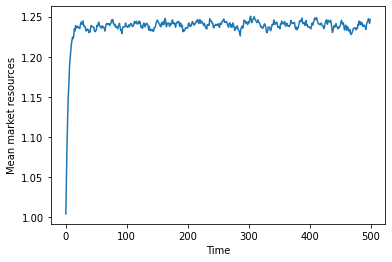

In [6]:
plt.plot(np.mean(KinkyExample.history['mNrm'], axis=1))
plt.xlabel("Time")
plt.ylabel("Mean market resources")
plt.show()

Now let's plot the distribution of (normalized) assets $a_t$ for the current population, after simulating for $500$ periods; this should be fairly close to the long run distribution:

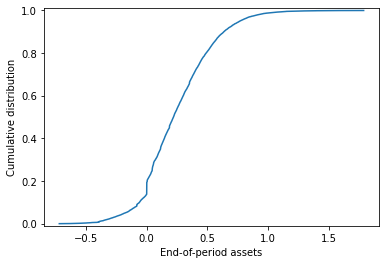

In [7]:
plt.plot(np.sort(KinkyExample.state_now['aNrm']), np.linspace(0.0, 1.0, KinkyExample.AgentCount))
plt.xlabel("End-of-period assets")
plt.ylabel("Cumulative distribution")
plt.ylim(-0.01, 1.01)
plt.show()

We can see there's a significant point mass of consumers with *exactly* $a_t=0$; these are consumers who do not find it worthwhile to give up a bit of consumption to begin saving (because $\Rfree_{save}$ is too low), and also are not willing to finance additional consumption by borrowing (because $\Rfree_{boro}$ is too high).

The smaller point masses in this distribution are due to $\texttt{HARK}$ drawing simulated income shocks from the discretized distribution, rather than the "true" lognormal distributions of shocks.  For consumers who ended $t-1$ with $a_{t-1}=0$ in assets, there are only 8 values the transitory shock $\theta_{t}$ can take on, and thus only 8 values of $m_t$ thus $a_t$ they can achieve; the value of $\psi_t$ is immaterial to $m_t$ when $a_{t-1}=0$.  You can verify this by changing $\texttt{TranShkCount}$ to some higher value, like 25, in the dictionary above, then running the subsequent cells; the smaller point masses will not be visible to the naked eye.